# **LM на базе LSTM**
*Домашнее задание №2 по курсу "Прикладная алгебра", вариант №3*

---

Выполнил студент 317 группы Зиннуров А.Р.


**Постановка задачи:** 
* Сделать LM на базе **LSTM**.
* Выбрать корпус для обучения. 
* Поэкспериментировать с разными гиперпараметрами (размерность скрытого представления, число слоёв и т.п.)
* Оценить качество генерируемого текста.

**Long Short-Term Memory (LSTM)** - это разновидность рекурентных нейронных сетей (**Recurrent Neural Network, RNN**) со следующей архитектурой:

$$
\begin{aligned}
i_{t} &=\sigma\left(W_{i i} x_{t}+b_{i i}+W_{h i} h_{t-1}+b_{h i}\right) \\
f_{t} &=\sigma\left(W_{i f} x_{t}+b_{i f}+W_{h f} h_{t-1}+b_{h f}\right) \\
g_{t} &=\tanh \left(W_{i g} x_{t}+b_{i g}+W_{h g} h_{t-1}+b_{h g}\right) \\
o_{t} &=\sigma\left(W_{i o} x_{t}+b_{i o}+W_{h o} h_{t-1}+b_{h o}\right) \\
c_{t} &=f_{t} \odot c_{t-1}+i_{t} \odot g_{t} \\
h_{t} &=o_{t} \odot \tanh \left(c_{t}\right)
\end{aligned}
$$

<center><img src=https://miro.medium.com/max/863/0*8rj0qHLOBK6t7L2z.png alt="image" width="600"/></center>

**Языковая модель (Language Model, LM)** - модель порождения новых слов, букв и т.д., которая назначает вероятности словам и предложениям.

<center><img src=https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png alt="image" width="600"/></center>

**Детали реализации:**
* Языковая модель обучается на словах.
* В качестве функции потерь используется кросс-энтропия.
* Датасет: **Large Movie Review Dataset**.

### Импорты, константы, девайс

In [130]:
import os
import time
import regex
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from collections import defaultdict

import nltk
nltk.download("stopwords")

import torch
import torchtext
from torch import nn
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence

STOPWORDS = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
# Девайс
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = "{0}".format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = "cuda:{0:d}".format(0)
else:
    device = torch.device("cpu")
print(f"Using device: {device}, dtype: {dtype}")

Using device: cuda:0, dtype: torch.float32


### Загрузка датасета

В качестве датасета используется [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/) - датасет с рецензиями на фильмы.

In [132]:
!wget "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2022-06-01 12:34:39--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  68.5MB/s    in 1.2s    

2022-06-01 12:34:40 (68.5 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [ ]:
!pip install torchtext==0.12.0
!tar -xzf aclImdb_v1.tar.gz

In [134]:
test_data_path = "aclImdb/test/"
train_data_path = "aclImdb/train/"

### Дополнительные функции

In [135]:
def tokenize(text):
    """
    Функция токенизации.
      1) Приводит текст к нижнему регистру.
      2) Убирает html разметку из текстов (<br />).
      3) Убирает все символы кроме латинских букв.
      4) Разбивает строку по пробелам.
      5) Убирает стоп слова.

    :param str text: Input text
    :return List[str]: List of words
    """
    text = text.lower()
    text = regex.sub("<.*?>", '', text)
    text = ''.join(c for c in text if c.isalpha() or (c == ' '))
    list_words = text.split()
    list_words = [word for word in list_words if word not in STOPWORDS]
    return list_words

In [136]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    Функция для объединения списка объектов в один батч.

    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.tensor(dtype=torch.long): sentiment of the text for each object in batch
            'texts' List[str]: All texts in one list
            'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    dict_output = {}
    dict_output["ratings"] = torch.tensor([obj["rating"].item() for obj in batch], dtype=torch.long)
    dict_output["labels"] = torch.tensor([obj["label"].item() for obj in batch], dtype=torch.long)
    dict_output["texts"] = [obj["text"] for obj in batch]
    dict_output["tokens"] = torch.nn.utils.rnn.pad_sequence([obj["tokens"] for obj in batch],
                                                            batch_first=batch_first,
                                                            padding_value=padding_value)
    dict_output["tokens_lens"] = torch.tensor([obj["tokens_len"].item() for obj in batch], dtype=torch.long)
    return dict_output

In [137]:
def print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens):
    """
    Печать сгенерированного текста.

    :param torch.tensor lm_model: lm model
    :param torch.tensor start_tokens: starting tokens
    :param torch.tensor start_tokens_lens: number of tokens for each object in batch
    :param torch.tensor decoded_tokens: decoded tokens
    :param torch.tensor decoded_lens: number of tokens for each object in batch
    """
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))

In [165]:
def print_graphic(list_train_losses, list_train_accuracies, list_test_losses,
                  list_test_accuracies, list_params=None, figsize=(20, 8)):
    """
    Функция печати графика.

    :param List(torch.tensor) list_train_losses: list losses on train
    :param List(torch.tensor) list_train_accuracies: list accuracies on train
    :param List(torch.tensor) list_test_losses: list losses on test
    :param List(torch.tensor) list_test_accuracies: list accuracies on test
    :param List(int), options list_params: list of parameters
    :param Tuple(int, int), options figsize: graph size
    """
    fig = plt.figure(figsize=figsize)
    colors = ['g', 'c', 'm', 'b', 'y', 'k', 'r'] # 7

    plt.subplot(1, 2, 1)
    plt.title("Зав-ть CrossEntropy от номера эпохи", fontsize=15)    
    plt.xlabel("Номер эпохи", fontsize=12)
    plt.ylabel("CrossEntropy", fontsize=12)
    position = list(range(len(list_train_losses[0])))
    for i in range(len(list_train_losses)):
        if not list_params:
            label = ''
        else:
            label = f": {list_params[i]}"
        plt.plot(position, list_train_losses[i], linestyle='--', c=colors[i], label="train" + label)
        plt.plot(position, list_test_losses[i], linestyle='-', c=colors[i], label="test" + label)
    plt.legend(fontsize=12)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("Зав-ть Accuracy от номера эпохи", fontsize=15)    
    plt.xlabel("Номер эпохи", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    for i in range(len(list_train_losses)):
        if not list_params:
            label = ''
        else:
            label = f": {list_params[i]}"
        plt.plot(position, list_train_accuracies[i], linestyle='--', c=colors[i], label="train" + label)
        plt.plot(position, list_test_accuracies[i], linestyle='-', c=colors[i], label="test" + label)
    plt.ylim((0.05, 0.2))
    plt.legend(fontsize=12)
    plt.grid()

    plt.show()

### Датасет

In [139]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        Класс датасета с обзорами на фильмы.

        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos>
        :param bool pad_eos: If True pad sequence at the end with <eos>
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(["<sos>"])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(["<eos>"])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, "neg")
        self.positive_path = os.path.join(data_path, "pos")
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            with open(path) as f:
                text = f.read()

            tokens = tokenize(text)
            tokens_ids = vocab.lookup_indices(tokens)
            tokens_ids = tokens_ids[:self.max_len]
            i_start = path.rfind('_')
            i_end = path.rfind('.')
            rating = int(path[i_start + 1: i_end]) - 1

            self.texts.append(text)
            self.tokens.append(tokens_ids)
            self.ratings.append(rating)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data
            {
                'text' str: unprocessed text,
                'label' torch.tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.tensor(dtype=torch.long): rating of the text
                'tokens' torch.tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.tensor(dtype=torch.long): number of tokens
            }
        """
        dict_output = {}
        dict_output["text"] = self.texts[idx]
        dict_output["label"] = torch.tensor(self.labels[idx], dtype=torch.long)
        dict_output["rating"] = torch.tensor(self.ratings[idx], dtype=torch.long)
        dict_output["tokens"] = torch.tensor(self.tokens[idx], dtype=torch.long)
        if self.pad_sos:
            dict_output["tokens"] = torch.tensor([self.sos_id] + dict_output["tokens"].tolist(), dtype=torch.long)
        if self.pad_eos:
            dict_output["tokens"] = torch.tensor(dict_output["tokens"].tolist() + [self.eos_id], dtype=torch.long)
        dict_output["tokens_len"] = torch.tensor(len(dict_output["tokens"]), dtype=torch.long)
        
        return dict_output
    
    def __len__(self):
        """
        :return int: number of objects in dataset
        """
        return len(self.texts)

### LM

In [140]:
class RNNClassifier(nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=nn.LSTM, dropout=None, **kwargs
    ):
        """
        Класс, реализующий классификатор на RNN.
        """
        super().__init__()

        self.dropout = dropout
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        # Use torch.nn.Embedding. Do not forget specify padding_idx!
        self.word_embeddings = nn.Embedding(len(self.vocab), self.embedding_dim, padding_idx=0)
        
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        self.linear = nn.Linear(hidden_dim, output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        
        # tokens: LxB, tokens_lens: B
        #  B - batch_size
        #  L - max length in batch
        #  H_em - self.embedding_dim
        #  H_out - self.hidden_dim
        #  H_final - self.output_size

        # Evaluate embeddings
        embeddings = self.word_embeddings(tokens) # LxBxH_em
        
        # Make forward pass through recurrent network
        h_all, (hn, cn) = self.rnn(embeddings) # LxBxH_out, 1xBxH_out, 1xBxH_out
        
        # Pass output from rnn to linear layer
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        output = self.linear(h_all[tokens_lens - 1, torch.arange(h_all.size(1)), :]) # BxH_final

        return output

In [141]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        """
        Класс, реализующий языковую модель (LM).
        """
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=nn.LSTM, dropout=dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens. Shape: [T, B]
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.tensor: Distribution of next token for each time step. Shape: [T, B, V], V -- size of vocabulary
        """
        # B - batch_size
        # T - max length in batch
        # H_em - self.embedding_dim
        # H_out - self.hidden_dim
        # V - size of vocabulary
        
        # Make embeddings for all tokens
        embeddings = self.word_embeddings(tokens) # TxBxH_em
        
        # Forward pass embeddings through network
        h_all, (hn, cn) = self.rnn(embeddings) # TxBxH_out, 1xBxH_out, 1xBxH_out
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        output = self.linear(h_all) # TxBxV
        
        return output

### CrossEntropy и Accuracy

In [142]:
class LMCrossEntropyLoss(nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        """
        Кросс-энтропийная функция потерь для LM.
        """
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch. Shape: [B]
        :return torch.tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        packed_outputs = pack_padded_sequence(outputs, tokens_lens.cpu() - 1, enforce_sorted=False).data
        packed_tokens = pack_padded_sequence(tokens[1:, :], tokens_lens.cpu() - 1, enforce_sorted=False).data
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        loss = super().forward(packed_outputs, packed_tokens)
        return loss

In [143]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        """
        Точности для LM.
        """
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.tensor tokens_lens: Length of each sequence in batch. Shape: [B]
        :return torch.tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        tokens_pred = torch.argmax(outputs, dim=2) # [T, B]
        packed_tokens_pred = pack_padded_sequence(tokens_pred, tokens_lens.cpu() - 1, enforce_sorted=False).data
        packed_tokens = pack_padded_sequence(tokens[1:, :], tokens_lens.cpu() - 1, enforce_sorted=False).data
        acc = torch.sum(packed_tokens_pred == packed_tokens)
        return acc

### Функции обучения

In [152]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    """
    Функция обучения на одной эпохе.
    """
    model.train()
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        
        # 1. Take data from batch
        tokens = data["tokens"].to(device)
        tokens_lens = data["tokens_lens"].to(device)
        
        # 2. Perform forward pass
        outputs = model(tokens, tokens_lens)
        
        # 3. Evaluate loss
        loss = loss_fn(outputs, tokens, tokens_lens)
        loss.backward()
        
        # 4. Make optimizer step
        optimizer.step()

In [153]:
def evaluate_lm(dataloader, model, loss_fn, device):
    """
    Функция оценки по одной эпохе.
    """
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            tokens = data["tokens"].to(device)
            tokens_lens = data["tokens_lens"].to(device)
            
            # 2. Perform forward pass
            outputs = model(tokens, tokens_lens)
            
            # 3. Evaluate loss
            loss = loss_fn(outputs, tokens, tokens_lens)
            total_loss += loss
            
            # 4. Evaluate accuracy
            accuracy = accuracy_fn(outputs, tokens, tokens_lens)
            total_accuracy += accuracy
            total_tokens += torch.sum(tokens_lens - 1)
            
    return total_loss / total_tokens, total_accuracy / total_tokens

In [154]:
def train_lm(train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs):
    """
    Функция обучения RNN.
    """
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc.cpu())
        train_losses.append(train_loss.cpu())
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc.cpu())
        test_losses.append(test_loss.cpu())
        
        print(
            "Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}".format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

### Декодер

In [147]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    Функция декодирования представлений в текст.

    :param RNNLM model: Model
    :param torch.tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :return Tuple[torch.tensor, torch.tensor]. Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # B - batch size
    # T - max length in batch for start tokens
    # T* - max length in batch for generated tokens
    # H_em - model.embedding_dim
    # H_hid - model.hidden_dim
    # V - size of vocabulary

    # Get embedding for start_tokens
    embedding = model.word_embeddings(start_tokens) # TxBxH_em
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim]) # (num_layers)xBxH_hid
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim]) # (num_layers)xBxH_hid
    for time_step in range(start_tokens.shape[0]):
        h_all, (hn, cn) = model.rnn(embedding[time_step][None, ...]) # 1xBxH_hid, (num_layers)xBxH_hid, (num_layers)xBxH_hid
        all_h.append(hn)
        all_c.append(cn)
    
    all_h = torch.stack(all_h, dim=1) # (num_layers)xTxBxH_hid
    all_c = torch.stack(all_c, dim=1) # (num_layers)xTxBxH_hid
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])] # (num_layers)xBxH_hid
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])] # (num_layers)xBxH_hid
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long) # B
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool) # B
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        logits = softmax(model.linear(h[1]), dim=1) # BxV
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = 0
            # Sample next_token. 
            next_token = torch.multinomial(logits, 1)[:,0]
        else:
            # Select most probable token
            next_token = torch.argmax(logits, dim=1) # B
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(["<eos>"])[0]))

        # Evaluate embedding for next token
        embedding = model.word_embeddings(next_token.reshape((1, -1))) # 1xBxH_em

        # Update hidden and cell states
        h_all, (h, c) = model.rnn(embedding, (h, c)) # 1xBxH_hid, (num_layers)xBxH_hid, (num_layers)xBxH_hid

    return torch.stack(predicted_tokens), decoded_lens # (T*)xB, B

### Обчение и применение LM

In [148]:
# Гиперпараметры
max_length = 20
top_n_words = 30000
max_generated_len = 20

hidden_dim = 512
embedding_dim = 512

num_layers = 2
dropout = 0.6
layers_dropout = 0.6

num_epochs = 12
batch_size = 96
learning_rate = 0.005
weight_decay = 1.2e-6

In [149]:
# Словарь с частотами встречаемости токенов
counter = defaultdict(int)
for path in ["aclImdb/test/neg", "aclImdb/test/pos", "aclImdb/train/neg", "aclImdb/train/pos"]:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding="utf-8", errors="ignore").read().strip()
        for token in tokenize(text):
            counter[token] += 1

# Отбрасывание низкочастотных слов
lm_counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True)[:top_n_words])

# Специальные токены
specials = ["<pad>", "<unk>", "<sos>", "<eos>"]
for special in specials:
    lm_counter[special] = 0

# Итоговый словарь
lm_vocab = torchtext.vocab.vocab(lm_counter, specials=specials, special_first=True)
lm_vocab.set_default_index(lm_vocab["<unk>"])

In [150]:
# Датасеты, даталоадеры
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=max_length, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=max_length, pad_sos=True, pad_eos=True)


lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(["<pad>"])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(["<pad>"])[0])
)

In [ ]:
# Модель, ф-ция потерь, оптимизатор
lm_model = RNNLM(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab=lm_vocab,
    dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
).to(device=device)

lm_loss_fn = LMCrossEntropyLoss(reduction="sum")
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# Обучение
start_time = time.time()
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, num_epochs
)
train_time_lm = time.time() - start_time
print(f"Время обучения: {train_time_lm // 60:.0f}m {train_time_lm % 60:.0f}s")

Epoch: 1/12. Loss (Train/Test): 7.423/7.602. Accuracy (Train/Test): 0.091/0.091
Epoch: 2/12. Loss (Train/Test): 7.245/7.525. Accuracy (Train/Test): 0.099/0.098
Epoch: 3/12. Loss (Train/Test): 7.042/7.438. Accuracy (Train/Test): 0.105/0.104
Epoch: 4/12. Loss (Train/Test): 6.910/7.437. Accuracy (Train/Test): 0.108/0.106
Epoch: 5/12. Loss (Train/Test): 6.693/7.398. Accuracy (Train/Test): 0.112/0.108
Epoch: 6/12. Loss (Train/Test): 6.524/7.416. Accuracy (Train/Test): 0.115/0.110
Epoch: 7/12. Loss (Train/Test): 6.362/7.475. Accuracy (Train/Test): 0.118/0.111
Epoch: 8/12. Loss (Train/Test): 6.182/7.525. Accuracy (Train/Test): 0.121/0.112
Epoch: 9/12. Loss (Train/Test): 6.018/7.591. Accuracy (Train/Test): 0.126/0.113
Epoch: 10/12. Loss (Train/Test): 5.831/7.683. Accuracy (Train/Test): 0.132/0.113
Epoch: 11/12. Loss (Train/Test): 5.660/7.781. Accuracy (Train/Test): 0.142/0.112
Epoch: 12/12. Loss (Train/Test): 5.489/7.882. Accuracy (Train/Test): 0.156/0.112
Время обучения: 5m 30s


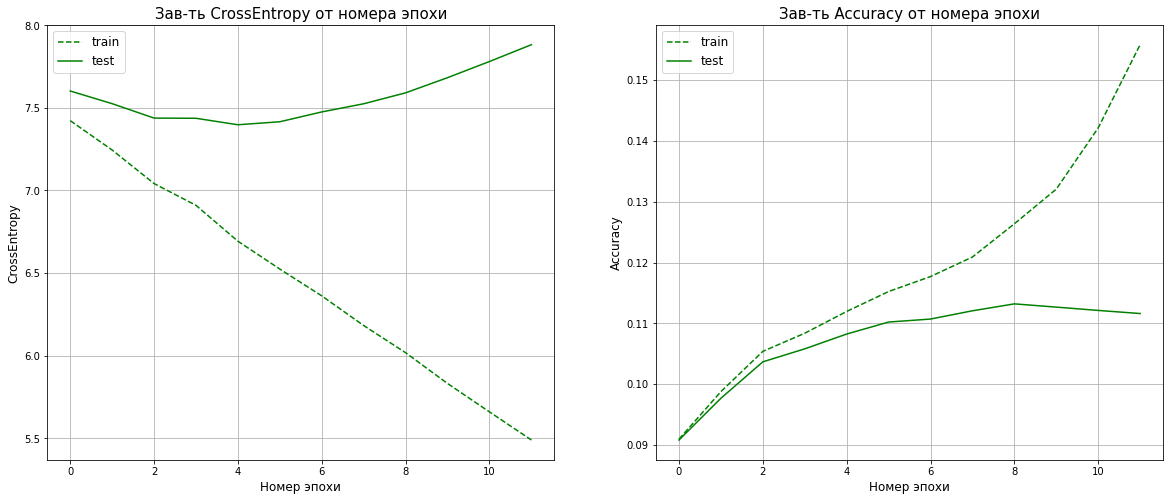

In [ ]:
# Вывод графиков
print_graphic([lm_train_losses], [lm_train_accuracies], [lm_test_losses], [lm_test_accuracies])

In [ ]:
# Примеры начала предложений
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(["<sos>", "<pad>", "<pad>", "<pad>"]),
    lm_model.vocab.lookup_indices(["<sos>", "my", "favorite", "movie"]),
    lm_model.vocab.lookup_indices(["<sos>", "the", "best", "movie"]),
    lm_model.vocab.lookup_indices(["<sos>", "the", "worst", "movie"]),
    lm_model.vocab.lookup_indices(["<sos>", "my", "name", "is"]),
    lm_model.vocab.lookup_indices(["<sos>", "i", "live", "in"]),
    lm_model.vocab.lookup_indices(["<sos>", "i", "love", "<pad>"]),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4, 4, 4, 3])

In [ ]:
# Стратегия жадного декодирования
device = "cpu"
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens,
                                      max_generated_len=max_generated_len, top_k=None)
print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens)

<sos> movie bad acting bad acting bad acting bad acting bad bad bad bad bad bad bad bad bad bad bad
<sos> <unk> favorite movie really bad <eos>
<sos> <unk> best movie really bad <eos>
<sos> <unk> worst movie really bad <eos>
<sos> <unk> name <unk> <unk> <eos>
<sos> <unk> live <unk> <unk> <eos>
<sos> <unk> love film <eos>


In [ ]:
# Стратегия Top-k sampling с top_k=5
device = "cpu"
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens,
                                      max_generated_len=max_generated_len, top_k=5)
print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens)

<sos> <unk> <unk> <unk> <unk> <unk> film made hohum <unk> <unk> <unk> <unk> del <unk> <unk> <unk> <unk> <unk> shinji <unk>
<sos> <unk> favorite movie starts special affects <eos>
<sos> <unk> best movie starts line <eos>
<sos> <unk> worst movie made <eos>
<sos> <unk> name <unk> <unk> <unk> <eos>
<sos> <unk> live <unk> see film <eos>
<sos> <unk> love movie really <eos>


In [ ]:
# Стратегия Top-k sampling с top_k=10
device = "cpu"
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens,
                                      max_generated_len=max_generated_len, top_k=10)
print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens)

<sos> <unk> <unk> <unk> <unk> <unk> made one thing prevents misleading movie starts well made movie really <unk> movie one worst
<sos> <unk> favorite movie <unk> story <eos>
<sos> <unk> best movie based us <eos>
<sos> <unk> worst movie ever <eos>
<sos> <unk> name <unk> would seem <eos>
<sos> <unk> live <unk> movie laden <eos>
<sos> <unk> love films like <eos>


In [ ]:
# Стратегия Top-k sampling с top_k=20
device = "cpu"
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens,
                                      max_generated_len=max_generated_len, top_k=20)
print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens)

<sos> saw movie tonight still liked movie watched first scene <unk> great actors like movie makes laugh cry time would think
<sos> <unk> favorite movie would like <eos>
<sos> <unk> best movie really disappointed <eos>
<sos> <unk> worst movie <unk> one <eos>
<sos> <unk> name <unk> <unk> <unk> <eos>
<sos> <unk> live <unk> first film <eos>
<sos> <unk> love director knows <eos>


In [ ]:
# Стратегия Top-k sampling с top_k=50
device = "cpu"
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens,
                                      max_generated_len=max_generated_len, top_k=50)
print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens)

<sos> thought really enjoyed film <unk> <unk> story <unk> <unk> starts <unk> <unk> <unk> <unk> <unk> replaces film really annoying well
<sos> <unk> favorite movie set impressionable <eos>
<sos> <unk> best movie didnt care <eos>
<sos> <unk> worst movie never never <eos>
<sos> <unk> name <unk> always saying <eos>
<sos> <unk> live <unk> <unk> pa <eos>
<sos> <unk> love television series <eos>


**Комментарий:** Результаты с использованием top-k получаются более полными, чем с жадным декодированием, которое быстро заканчивает предложения выше. Объясняется это высокой вероятностью немногочисленного кол-ва слов и невозможностью увидеть более вероятные последовательности слов. При этом, увеличивая top-k до некоторого значения, мы будем всё время улучшать выдаваемые предложения, которые будут становиться более богатыми и разнообразными, однако если взять слишком большое значение, то все предложения станут слишком общими. Далее будем использовать top-k, равный 10.

### Эксперименты

#### Число слоёв

In [151]:
device

'cuda:0'

In [ ]:
# Гиперпараметры
list_num_layers = [1, 2, 3, 4] # 4

list_lm_train_losses = []
list_lm_train_accuracies = []
list_lm_test_losses = []
list_lm_test_accuracies = []
list_times = []
for num_layers in list_num_layers:
    # Модель, ф-ция потерь, оптимизатор
    lm_model = RNNLM(
        embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab=lm_vocab,
        dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
    ).to(device=device)
    lm_loss_fn = LMCrossEntropyLoss(reduction="sum")
    lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Обучение
    start_time = time.time()
    lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
        lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, num_epochs
    )
    train_time_lm = time.time() - start_time
    print(f"Время обучения: {train_time_lm // 60:.0f}m {train_time_lm % 60:.0f}s")

    list_lm_train_losses.append(lm_train_losses)
    list_lm_train_accuracies.append(lm_train_accuracies)
    list_lm_test_losses.append(lm_test_losses)
    list_lm_test_accuracies.append(lm_test_accuracies)
    list_times.append(train_time_lm)

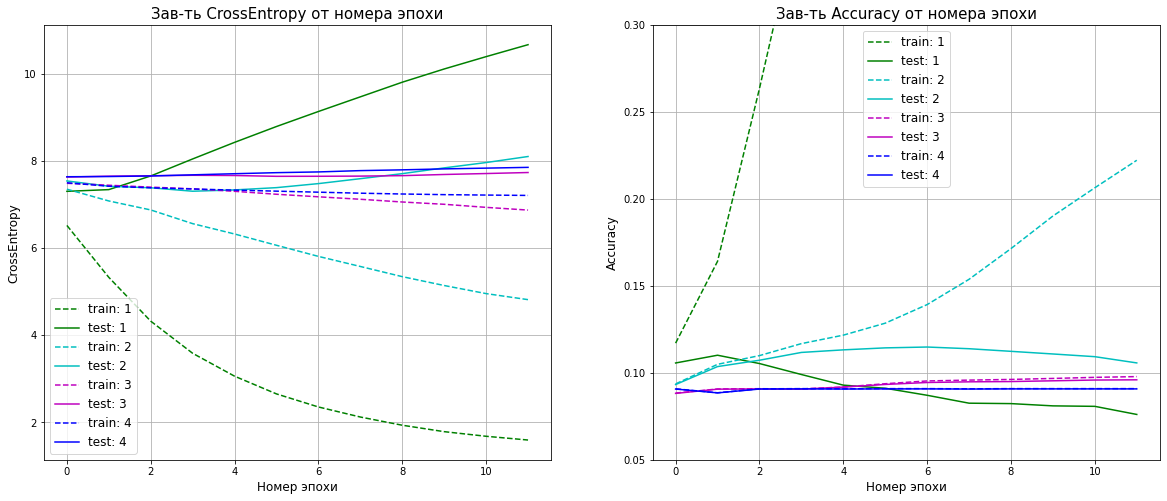

In [160]:
# Вывод графиков
print_graphic(list_lm_train_losses, list_lm_train_accuracies, list_lm_test_losses,
              list_lm_test_accuracies, list_num_layers)

**Комментарий:** Лучшая глубина равна 2. Примеры генерации совпадают с примерами выше.

#### Размер скрытого представления

In [163]:
# Гиперпараметры
device = "cuda:0"
num_layers = 2
list_hidden_dim = [128, 256, 512, 1024] # 4

list_lm_train_losses = []
list_lm_train_accuracies = []
list_lm_test_losses = []
list_lm_test_accuracies = []
list_times = []
for hidden_dim in list_hidden_dim:
    # Даталоадеры
    lm_test_dataloader = DataLoader(
        lm_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
        collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(["<pad>"])[0])
    )
    lm_train_dataloader = DataLoader(
        lm_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
        collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(["<pad>"])[0])
    )

    # Модель, ф-ция потерь, оптимизатор
    lm_model = RNNLM(
        embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab=lm_vocab,
        dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
    ).to(device=device)
    lm_loss_fn = LMCrossEntropyLoss(reduction="sum")
    lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Обучение
    start_time = time.time()
    lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
        lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, num_epochs
    )
    train_time_lm = time.time() - start_time
    print(f"Время обучения: {train_time_lm // 60:.0f}m {train_time_lm % 60:.0f}s")

    list_lm_train_losses.append(lm_train_losses)
    list_lm_train_accuracies.append(lm_train_accuracies)
    list_lm_test_losses.append(lm_test_losses)
    list_lm_test_accuracies.append(lm_test_accuracies)
    list_times.append(train_time_lm)

Epoch: 1/12. Loss (Train/Test): 7.445/7.604. Accuracy (Train/Test): 0.090/0.089
Epoch: 2/12. Loss (Train/Test): 7.253/7.501. Accuracy (Train/Test): 0.097/0.096
Epoch: 3/12. Loss (Train/Test): 7.088/7.439. Accuracy (Train/Test): 0.102/0.100
Epoch: 4/12. Loss (Train/Test): 6.933/7.386. Accuracy (Train/Test): 0.108/0.105
Epoch: 5/12. Loss (Train/Test): 6.811/7.382. Accuracy (Train/Test): 0.109/0.105
Epoch: 6/12. Loss (Train/Test): 6.682/7.359. Accuracy (Train/Test): 0.112/0.108
Epoch: 7/12. Loss (Train/Test): 6.593/7.395. Accuracy (Train/Test): 0.113/0.107
Epoch: 8/12. Loss (Train/Test): 6.465/7.384. Accuracy (Train/Test): 0.117/0.110
Epoch: 9/12. Loss (Train/Test): 6.392/7.422. Accuracy (Train/Test): 0.117/0.109
Epoch: 10/12. Loss (Train/Test): 6.289/7.429. Accuracy (Train/Test): 0.121/0.112
Epoch: 11/12. Loss (Train/Test): 6.202/7.455. Accuracy (Train/Test): 0.123/0.112
Epoch: 12/12. Loss (Train/Test): 6.142/7.509. Accuracy (Train/Test): 0.122/0.110
Время обучения: 3m 5s
Epoch: 1/12. Lo

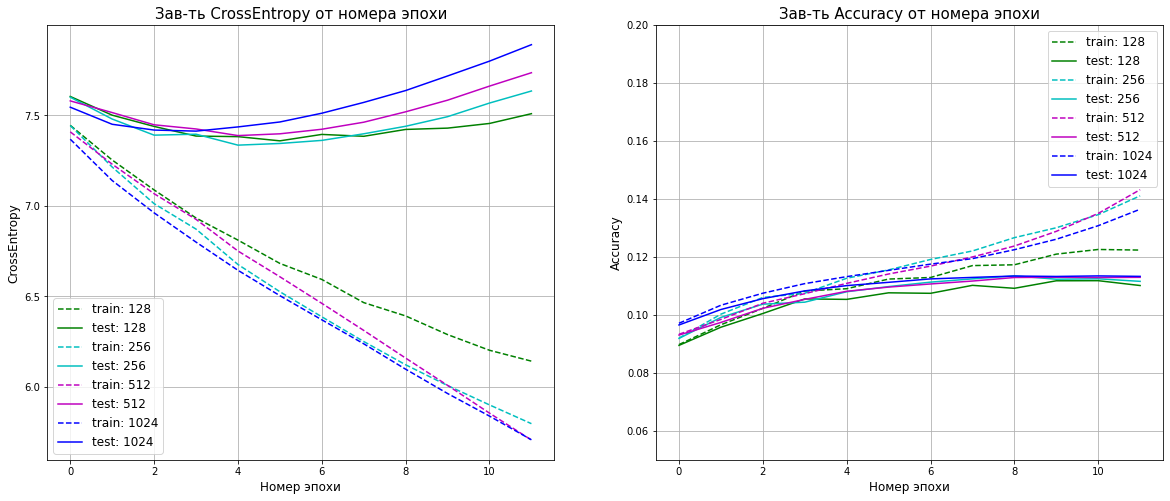

In [166]:
# Вывод графиков
print_graphic(list_lm_train_losses, list_lm_train_accuracies, list_lm_test_losses,
              list_lm_test_accuracies, list_hidden_dim)

In [167]:
# Примеры начала предложений
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(["<sos>", "<pad>", "<pad>", "<pad>"]),
    lm_model.vocab.lookup_indices(["<sos>", "my", "favorite", "movie"]),
    lm_model.vocab.lookup_indices(["<sos>", "the", "best", "movie"]),
    lm_model.vocab.lookup_indices(["<sos>", "the", "worst", "movie"]),
    lm_model.vocab.lookup_indices(["<sos>", "my", "name", "is"]),
    lm_model.vocab.lookup_indices(["<sos>", "i", "live", "in"]),
    lm_model.vocab.lookup_indices(["<sos>", "i", "love", "<pad>"]),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4, 4, 4, 3])

In [168]:
# Стратегия Top-k sampling с top_k=10
device = "cpu"
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens,
                                      max_generated_len=max_generated_len, top_k=10)
print_text(lm_model, start_tokens, start_tokens_lens, decoded_tokens, decoded_lens)

<sos> really bad movie <unk> movie <unk> bad acting bad movie <unk> really good job well acted one movie shows lot
<sos> <unk> favorite movie bad movie made laugh bad guy <eos>
<sos> <unk> best movie <unk> character actor supposed predictable acting good <eos>
<sos> <unk> worst movie bad casting bad casting terrible plot bad <eos>
<sos> <unk> name <unk> <unk> <unk> film <unk> <unk> movie bad script horrible <eos>
<sos> <unk> live <unk> story <unk> film <eos>
<sos> <unk> love show <unk> <eos>


**Комментарий:** **LSTM** с 1024 параметрами быстрее сходится и показывает аналогичную точность сети с 512 параметрами. Оставшиеся сети показывают результаты хуже.

**Вывод:**
* Реализована LM на базе **LSTM**.
* Произведены эксперименты с разными гиперпараметрами:
    * размерность эмбединга;
    * число слоёв.
* Получены численные и качественные сравнения генерируемого текста.